In [252]:
# 载入库
import time
import datetime
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
 
import warnings
warnings.filterwarnings('ignore')
 
# 五种基础模型
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

# k-交叉折叠
from sklearn.model_selection import KFold;

print("libs ok~")

libs ok~


In [275]:
# 载入数据
# train_neg = pd.read_csv('neg.csv', na_values=['\\N'])
# train_pos = pd.read_csv('pos.csv', na_values=['\\N'])
# test = pd.read_csv('pre_all.csv', na_values=['\\N'])
train_neg = pd.read_csv('neg_all.csv', na_values=['\\N'])
train_pos = pd.read_csv('pos_all.csv', na_values=['\\N'])
test = pd.read_csv('pre_all.csv', na_values=['\\N'])
train = pd.concat([train_neg, train_pos])

# Store our passenger ID for easy access
# PassengerId = test['PassengerId']
 
train.head(3)
train.describe()
train.shape
train = train[train['avg_kill'] < 10]
test = test[test['avg_kill'] < 10]

In [276]:
full_data = [train, test]

for data_set in full_data:
    
    data_set.fillna(0, inplace=True)
    
#     data_set.drop(['quest_cnt.1'], axis = 1)
    
    data_set['game_time'] = data_set['play_cnt'] * data_set['avg_livetime'];
    data_set.loc[(data_set['game_time'] > 0) & (data_set['game_time'] <= 1000), 'game_time'] = 1
    data_set.loc[(data_set['game_time'] >1000) & (data_set['game_time'] <= 5000), 'game_time'] = 2
    data_set.loc[(data_set['game_time'] >5000) & (data_set['game_time'] <= 10000), 'game_time'] = 3
    data_set.loc[(data_set['game_time'] >10000) & (data_set['game_time'] <= 15000), 'game_time'] = 4
    data_set.loc[(data_set['game_time'] >15000) & (data_set['game_time'] <= 20000), 'game_time'] = 5
    data_set.loc[(data_set['game_time'] >20000) & (data_set['game_time'] <= 25000), 'game_time'] = 6
    data_set.loc[(data_set['game_time'] >25000) & (data_set['game_time'] <= 30000), 'game_time'] = 7
    data_set.loc[(data_set['game_time'] >30000), 'game_time'] = 8
#     data_set['game_time'] = data_set['game_time'].astype("int")
#     data_set['game_time'] = data_set['game_time'].astype("str")
    
    data_set['create_date'] = data_set['create_date'] + data_set['create_date.1'] 
    data_set.drop(['create_date.1'], axis = 1, inplace=True)
    data_set['create_date'] = data_set['create_date'].astype(str)
    data_set['create_date'] = data_set['create_date'].apply(lambda x : x[0 : -4])
    data_set['create_date'] = pd.to_datetime(data_set['create_date'])
    str_today = time.strftime('%Y%m%d',time.localtime(time.time()))
    today = pd.to_datetime(str_today, format='%Y%m%d', errors='ignore')
    data_set['register_day'] = data_set['create_date'].apply(lambda x : (today - x).days)
    data_set.drop(['create_date'], axis = 1, inplace=True)
    data_set.loc[(data_set['register_day'] >= 0) & (data_set['register_day'] <= 30), 'register_day'] = 1
    data_set.loc[(data_set['register_day'] >30) & (data_set['register_day'] <= 60), 'register_day'] = 2
    data_set.loc[(data_set['register_day'] >60) & (data_set['register_day'] <= 90), 'register_day'] = 3
    data_set.loc[(data_set['register_day'] >90) & (data_set['register_day'] <= 180), 'register_day'] = 4
    data_set.loc[(data_set['register_day'] >180) & (data_set['register_day'] <= 360), 'register_day'] = 5
    data_set.loc[(data_set['register_day'] >360) & (data_set['register_day'] <= 720), 'register_day'] = 6
    data_set.loc[(data_set['register_day'] >720), 'register_day'] = 7
#     data_set['register_day'] = data_set['register_day'].astype("int")
#     data_set['register_day'] = data_set['register_day'].astype("str")
    
    data_set.loc[(data_set['login_cnt'] >0) & (data_set['login_cnt'] <= 5), 'login_cnt'] = 1
    data_set.loc[(data_set['login_cnt'] >5) & (data_set['login_cnt'] <= 10), 'login_cnt'] = 2
    data_set.loc[(data_set['login_cnt'] >10) & (data_set['login_cnt'] <= 30), 'login_cnt'] = 3
    data_set.loc[(data_set['login_cnt'] >30) & (data_set['login_cnt'] <= 60), 'login_cnt'] = 4
    data_set.loc[(data_set['login_cnt'] >60) & (data_set['login_cnt'] <= 100), 'login_cnt'] = 5
    data_set.loc[(data_set['login_cnt'] >100), 'login_cnt'] = 6
#     data_set['login_cnt'] = data_set['login_cnt'].astype("int")
#     data_set['login_cnt'] = data_set['login_cnt'].astype("str")
    
    data_set.loc[(data_set['quest_cnt'] >0) & (data_set['quest_cnt'] <= 10), 'quest_cnt'] = 1
    data_set.loc[(data_set['quest_cnt'] >10) & (data_set['quest_cnt'] <= 30), 'quest_cnt'] = 2
    data_set.loc[(data_set['quest_cnt'] >30) & (data_set['quest_cnt'] <= 50), 'quest_cnt'] = 3
    data_set.loc[(data_set['quest_cnt'] >50) & (data_set['quest_cnt'] <= 75), 'quest_cnt'] = 4
    data_set.loc[(data_set['quest_cnt'] >75), 'quest_cnt'] = 5
    data_set.drop(['quest_cnt.1'], axis = 1, inplace=True)
#     data_set['quest_cnt'] = data_set['quest_cnt'].astype("int")
#     data_set['quest_cnt'] = data_set['quest_cnt'].astype("str")
    
    data_set.loc[(data_set['sigle_match_cnt'] >0) & (data_set['sigle_match_cnt'] <= 5), 'sigle_match_cnt'] = 1
    data_set.loc[(data_set['sigle_match_cnt'] >5) & (data_set['sigle_match_cnt'] <= 10), 'sigle_match_cnt'] = 2
    data_set.loc[(data_set['sigle_match_cnt'] >10) & (data_set['sigle_match_cnt'] <= 20), 'sigle_match_cnt'] = 3
    data_set.loc[(data_set['sigle_match_cnt'] >20) & (data_set['sigle_match_cnt'] <= 50), 'sigle_match_cnt'] = 4
    data_set.loc[(data_set['sigle_match_cnt'] >50), 'sigle_match_cnt'] = 5
#     data_set['sigle_match_cnt'] = data_set['sigle_match_cnt'].astype("int")
#     data_set['sigle_match_cnt'] = data_set['sigle_match_cnt'].astype("str")
    
    data_set.loc[(data_set['team_match_cnt'] >0) & (data_set['team_match_cnt'] <= 5), 'team_match_cnt'] = 1
    data_set.loc[(data_set['team_match_cnt'] >5) & (data_set['team_match_cnt'] <= 10), 'team_match_cnt'] = 2
    data_set.loc[(data_set['team_match_cnt'] >10) & (data_set['team_match_cnt'] <= 20), 'team_match_cnt'] = 3
    data_set.loc[(data_set['team_match_cnt'] >20) & (data_set['team_match_cnt'] <= 50), 'team_match_cnt'] = 4
    data_set.loc[(data_set['team_match_cnt'] >50), 'team_match_cnt'] = 5
#     data_set['team_match_cnt'] = data_set['team_match_cnt'].astype("int")
#     data_set['team_match_cnt'] = data_set['team_match_cnt'].astype("str")
    
    data_set['lonely_rate'] = data_set['sigle_match_cnt'] / ( data_set['team_match_cnt'] + 1);
    
    data_set.loc[(data_set['play_cnt'] >0) & (data_set['play_cnt'] <= 5), 'play_cnt'] = 1
    data_set.loc[(data_set['play_cnt'] >5) & (data_set['play_cnt'] <= 10), 'play_cnt'] = 2
    data_set.loc[(data_set['play_cnt'] >10) & (data_set['play_cnt'] <= 20), 'play_cnt'] = 3
    data_set.loc[(data_set['play_cnt'] >20) & (data_set['play_cnt'] <= 50), 'play_cnt'] = 4
    data_set.loc[(data_set['play_cnt'] >50) & (data_set['play_cnt'] <= 100), 'play_cnt'] = 5
    data_set.loc[(data_set['play_cnt'] >100), 'play_cnt'] = 6
#     data_set['play_cnt'] = data_set['play_cnt'].astype("int")
#     data_set['play_cnt'] = data_set['play_cnt'].astype("str")
    
    data_set.loc[(data_set['avg_kill'] >0) & (data_set['avg_kill'] <= 0.5), 'avg_kill'] = 1
    data_set.loc[(data_set['avg_kill'] >0.5) & (data_set['avg_kill'] <= 1), 'avg_kill'] = 2
    data_set.loc[(data_set['avg_kill'] >1) & (data_set['avg_kill'] <= 3), 'avg_kill'] = 3
    data_set.loc[(data_set['avg_kill'] >3) & (data_set['avg_kill'] <= 5), 'avg_kill'] = 4
    data_set.loc[(data_set['avg_kill'] >5) & (data_set['avg_kill'] <= 10), 'avg_kill'] = 5
    data_set.loc[(data_set['avg_kill'] >10), 'avg_kill'] = 6
#     data_set['avg_kill'] = data_set['avg_kill'].astype("int")
#     data_set['avg_kill'] = data_set['avg_kill'].astype("str")
    
    data_set.loc[(data_set['avg_hurt'] >0) & (data_set['avg_hurt'] <= 100), 'avg_hurt'] = 1
    data_set.loc[(data_set['avg_hurt'] >100) & (data_set['avg_hurt'] <= 300), 'avg_hurt'] = 2
    data_set.loc[(data_set['avg_hurt'] >300) & (data_set['avg_hurt'] <= 500), 'avg_hurt'] = 3
    data_set.loc[(data_set['avg_hurt'] >500) & (data_set['avg_hurt'] <= 750), 'avg_hurt'] = 4
    data_set.loc[(data_set['avg_hurt'] >750) & (data_set['avg_hurt'] <= 1000), 'avg_hurt'] = 5
    data_set.loc[(data_set['avg_hurt'] >1000) & (data_set['avg_hurt'] <= 1500), 'avg_hurt'] = 6
    data_set.loc[(data_set['avg_hurt'] >1500) & (data_set['avg_hurt'] <= 2000), 'avg_hurt'] = 7
    data_set.loc[(data_set['avg_hurt'] >2000) & (data_set['avg_hurt'] <= 5000), 'avg_hurt'] = 8
    data_set.loc[(data_set['avg_hurt'] >5000), 'avg_hurt'] = 9
#     data_set['avg_hurt'] = data_set['avg_hurt'].astype("int")
#     data_set['avg_hurt'] = data_set['avg_hurt'].astype("str")
    
    data_set.loc[(data_set['avg_livetime'] >0) & (data_set['avg_livetime'] <= 100), 'avg_livetime'] = 1
    data_set.loc[(data_set['avg_livetime'] >100) & (data_set['avg_livetime'] <= 300), 'avg_livetime'] = 2
    data_set.loc[(data_set['avg_livetime'] >300) & (data_set['avg_livetime'] <= 500), 'avg_livetime'] = 3
    data_set.loc[(data_set['avg_livetime'] >500) & (data_set['avg_livetime'] <= 750), 'avg_livetime'] = 4
    data_set.loc[(data_set['avg_livetime'] >750) & (data_set['avg_livetime'] <= 1000), 'avg_livetime'] = 5
    data_set.loc[(data_set['avg_livetime'] >1000) & (data_set['avg_livetime'] <= 1500), 'avg_livetime'] = 6
    data_set.loc[(data_set['avg_livetime'] >1000), 'avg_livetime'] = 7
#     data_set['avg_livetime'] = data_set['avg_livetime'].astype("int")
#     data_set['avg_livetime'] = data_set['avg_livetime'].astype("str")
    
    data_set.loc[(data_set['rank'] >0), 'rank'] = 1
    
    data_set.loc[(data_set['spend_money'] >0) & (data_set['spend_money'] <= 1000), 'spend_money'] = 1
    data_set.loc[(data_set['spend_money'] >1000), 'spend_money'] = 2
#     data_set['spend_money'] = data_set['spend_money'].astype("int")
#     data_set['spend_money'] = data_set['spend_money'].astype("str")
    
    data_set.loc[(data_set['creat_use'] ==0), 'crate_use'] = 0
    data_set.loc[(data_set['creat_use'] >0) & (data_set['creat_use'] <= 3), 'crate_use'] = 1
    data_set.loc[(data_set['creat_use'] >3) & (data_set['creat_use'] <= 7), 'crate_use'] = 2
    data_set.loc[(data_set['creat_use'] >8) & (data_set['creat_use'] <= 10), 'crate_use'] = 3
    data_set.loc[(data_set['creat_use'] >10), 'crate_use'] = 4
    data_set.drop(['creat_use'], axis = 1, inplace=True)
#     data_set['crate_use'] = data_set['crate_use'].astype("int")
#     data_set['crate_use'] = data_set['crate_use'].astype("str")
    
    data_set.loc[(data_set['friend_add'] >0) & (data_set['friend_add'] <= 5), 'friend_add'] = 1
    data_set.loc[(data_set['friend_add'] >5) & (data_set['friend_add'] <= 10), 'friend_add'] = 2
    data_set.loc[(data_set['friend_add'] >10), 'friend_add'] = 3
#     data_set['friend_add'] = data_set['friend_add'].astype("int")
#     data_set['friend_add'] = data_set['friend_add'].astype("str")
    
    data_set.loc[(data_set['friend_del'] >0) & (data_set['friend_del'] <= 5), 'friend_del'] = 1
    data_set.loc[(data_set['friend_del'] >5) & (data_set['friend_del'] <= 10), 'friend_del'] = 2
    data_set.loc[(data_set['friend_del'] >10), 'friend_del'] = 3
#     data_set['friend_del'] = data_set['friend_del'].astype("int")
#     data_set['friend_del'] = data_set['friend_del'].astype("str")
    
    
    data_set.loc[(data_set['tier'] >0) & (data_set['tier'] <= 10), 'tier'] = 1
    data_set.loc[(data_set['tier'] >10) & (data_set['tier'] <= 30), 'tier'] = 2
    data_set.loc[(data_set['tier'] >30) & (data_set['tier'] <= 50), 'tier'] = 3
    data_set.loc[(data_set['tier'] >50) & (data_set['tier'] <= 75), 'tier'] = 4
    data_set.loc[(data_set['tier'] >75), 'tier'] = 5
#     data_set['tier'] = data_set['tier'].astype("int")
#     data_set['tier'] = data_set['tier'].astype("str")
    
    data_set['bp'] = data_set['bp_new'] + data_set['bp_old'] 
    data_set.drop(['bp_new'], axis = 1, inplace=True)
    data_set.drop(['bp_old'], axis = 1, inplace=True)
    
    data_set['free_fuck'] = data_set['free_fuck_new'] + data_set['free_fuck_old'] 
    data_set.drop(['free_fuck_new'], axis = 1, inplace=True)
    data_set.drop(['free_fuck_old'], axis = 1, inplace=True)
    
    if 'country' in data_set.columns:
        data_set.drop(['country'], axis = 1, inplace=True)
    
# train.loc[(train['create_date'] == 0) & (train['create_date.1'] == 0) & (train['label'] == 0)].head(100)
# train['create_date_real'] = train['create_date'].apply(lambda x : x if x > 0and else 0)
test.loc[(test['label'] == 0), 'label'] = 1
test.loc[(test['label'] > 1), 'label'] = 0
train.head(5)

,avg_hurt,avg_kill,avg_livetime,friend_add,friend_del,label,login_cnt,play_cnt,quest_cnt,rank,sigle_match_cnt,spend_money,team_match_cnt,tier,game_time,register_day,lonely_rate,crate_use,bp,free_fuck
1,9.0,5.0,6.0,0.0,0.0,0,1,2.0,1,0.0,2.0,0.0,0.0,1.0,3.0,2.0,2.000000,1.0,0.0,0.0
2,7.0,3.0,3.0,1.0,0.0,0,3,3.0,1,0.0,1.0,0.0,2.0,1.0,2.0,3.0,0.333333,1.0,1.0,0.0
3,9.0,5.0,6.0,0.0,0.0,0,2,4.0,1,1.0,4.0,0.0,1.0,1.0,7.0,2.0,2.000000,0.0,0.0,1.0
4,7.0,3.0,5.0,0.0,0.0,0,1,3.0,1,1.0,1.0,0.0,3.0,1.0,4.0,2.0,0.250000,1.0,0.0,1.0
6,8.0,5.0,6.0,0.0,0.0,0,1,1.0,0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,1.000000,1.0,0.0,0.0


In [224]:
full_data = [train, test]

days = 14

for data_set in full_data:
    
    data_set.fillna(0, inplace=True)
    
    
    data_set['create_date'] = data_set['create_date'] + data_set['create_date.1'] 
    data_set.drop(['create_date.1'], axis = 1, inplace=True)
    data_set['create_date'] = data_set['create_date'].astype(str)
    data_set['create_date'] = data_set['create_date'].apply(lambda x : x[0 : -4])
    data_set['create_date'] = pd.to_datetime(data_set['create_date'])
    str_today = time.strftime('%Y%m%d',time.localtime(time.time()))
    today = pd.to_datetime(str_today, format='%Y%m%d', errors='ignore')
    data_set['register_day'] = data_set['create_date'].apply(lambda x : (today - x).days)
    data_set.drop(['create_date'], axis = 1, inplace=True)
    data_set.loc[(data_set['register_day'] >= 0) & (data_set['register_day'] <= 30), 'register_day'] = 1
    data_set.loc[(data_set['register_day'] >30) & (data_set['register_day'] <= 60), 'register_day'] = 2
    data_set.loc[(data_set['register_day'] >60) & (data_set['register_day'] <= 90), 'register_day'] = 3
    data_set.loc[(data_set['register_day'] >90) & (data_set['register_day'] <= 180), 'register_day'] = 4
    data_set.loc[(data_set['register_day'] >180) & (data_set['register_day'] <= 360), 'register_day'] = 5
    data_set.loc[(data_set['register_day'] >360) & (data_set['register_day'] <= 720), 'register_day'] = 6
    data_set.loc[(data_set['register_day'] >720), 'register_day'] = 7
    
    data_set['login_cnt'] = data_set['login_cnt'] / days
    data_set['quest_cnt'] = data_set['quest_cnt'] / days
    data_set.drop(['quest_cnt.1'], axis = 1, inplace=True)
    
    data_set['sigle_match_cnt'] = data_set['sigle_match_cnt'] / days
    data_set['team_match_cnt'] = data_set['team_match_cnt'] / days
    data_set['play_cnt'] = data_set['play_cnt'] / days
    data_set['spend_money'] = data_set['spend_money'] / days
    data_set['crate_use'] = data_set['creat_use'] / days
    data_set.drop(['creat_use'], axis = 1, inplace=True)
    data_set['friend_add'] = data_set['friend_add'] / days
    data_set['friend_del'] = data_set['friend_del'] / days
    
    data_set['lonely_rate'] = data_set['sigle_match_cnt'] / ( data_set['team_match_cnt'] + 1);
    
    data_set.loc[(data_set['rank'] >0), 'rank'] = 1
    
    data_set.loc[(data_set['tier'] >0) & (data_set['tier'] <= 10), 'tier'] = 1
    data_set.loc[(data_set['tier'] >10) & (data_set['tier'] <= 30), 'tier'] = 2
    data_set.loc[(data_set['tier'] >30) & (data_set['tier'] <= 50), 'tier'] = 3
    data_set.loc[(data_set['tier'] >50) & (data_set['tier'] <= 75), 'tier'] = 4
    data_set.loc[(data_set['tier'] >75), 'tier'] = 5
    
    data_set['bp'] = data_set['bp_new'] + data_set['bp_old'] 
    data_set.drop(['bp_new'], axis = 1, inplace=True)
    data_set.drop(['bp_old'], axis = 1, inplace=True)
    
    data_set['free_fuck'] = data_set['free_fuck_new'] + data_set['free_fuck_old'] 
    data_set.drop(['free_fuck_new'], axis = 1, inplace=True)
    data_set.drop(['free_fuck_old'], axis = 1, inplace=True)
    
    if 'country' in data_set.columns:
        data_set.drop(['country'], axis = 1, inplace=True)
    
# train.loc[(train['create_date'] == 0) & (train['create_date.1'] == 0) & (train['label'] == 0)].head(100)
# train['create_date_real'] = train['create_date'].apply(lambda x : x if x > 0and else 0)
test.loc[(test['label'] == 0), 'label'] = 1
test.loc[(test['label'] > 1), 'label'] = 0
train.head(5)

,avg_hurt,avg_kill,avg_livetime,friend_add,friend_del,label,login_cnt,play_cnt,quest_cnt,rank,sigle_match_cnt,spend_money,team_match_cnt,tier,register_day,crate_use,lonely_rate,bp,free_fuck
0,9760.000000,11.000000,915.000000,0.000000,0.0,0,0.071429,0.142857,0.000000,0.0,0.142857,0.0,0.071429,1.0,2.0,0.071429,0.133333,0.0,0.0
1,8527.166667,9.166667,1254.500000,0.000000,0.0,0,0.142857,0.428571,0.071429,0.0,0.571429,0.0,0.000000,1.0,2.0,0.071429,0.571429,0.0,0.0
2,1884.000000,1.909091,333.545455,0.142857,0.0,0,1.428571,0.785714,0.214286,0.0,0.285714,0.0,0.428571,1.0,3.0,0.214286,0.200000,1.0,0.0
3,5238.375000,5.791667,1199.541667,0.000000,0.0,0,0.500000,1.714286,0.142857,1.0,2.357143,0.0,0.071429,1.0,2.0,0.000000,2.200000,0.0,1.0
4,1529.928571,1.357143,804.071429,0.000000,0.0,0,0.071429,1.000000,0.214286,1.0,0.142857,0.0,0.928571,1.0,2.0,0.142857,0.074074,0.0,1.0


In [277]:
train = train.dropna(axis=0,how='any')
test = test.dropna(axis=0,how='any')

# full_data = [train, test]

# for tmp in full_data:
#     tmp['game_time'] = tmp['game_time'].astype("int").astype("str")
#     tmp['login_cnt'] = tmp['login_cnt'].astype("int").astype("str")
#     tmp['quest_cnt'] = tmp['quest_cnt'].astype("int").astype("str")
#     tmp['sigle_match_cnt'] = tmp['sigle_match_cnt'].astype("int").astype("str")
#     tmp['play_cnt'] = tmp['play_cnt'].astype("int").astype("str")
#     tmp['avg_kill'] = tmp['avg_kill'].astype("int").astype("str")
#     tmp['avg_hurt'] = tmp['avg_hurt'].astype("int").astype("str")
#     tmp['avg_livetime'] = tmp['avg_livetime'].astype("int").astype("str")
#     tmp['spend_money'] = tmp['spend_money'].astype("int").astype("str")
#     tmp['friend_add'] = tmp['friend_add'].astype("int").astype("str")
#     tmp['avg_livetime'] = tmp['avg_livetime'].astype("int").astype("str")
#     tmp['friend_del'] = tmp['friend_del'].astype("int").astype("str")
#     tmp['tier'] = tmp['tier'].astype("int").astype("str")
#     tmp['crate_use'] = tmp['crate_use'].astype("int").astype("str")
#     tmp['team_match_cnt'] = tmp['team_match_cnt'].astype("int").astype("str")
    
#     tmp['rank'] = tmp['rank'].astype("int")
#     tmp['register_day'] = tmp['register_day'].astype("int")
#     tmp['bp'] = tmp['bp'].astype("int")
#     tmp['free_fuck'] = tmp['free_fuck'].astype("int")
    
# train_input = pd.get_dummies(train) 
# test_input = pd.get_dummies(test)
train_input = train
test_input = test
# train_input.dtypes
print(train_input.shape)
print(test_input.shape)

(229998, 20)
(32834, 20)


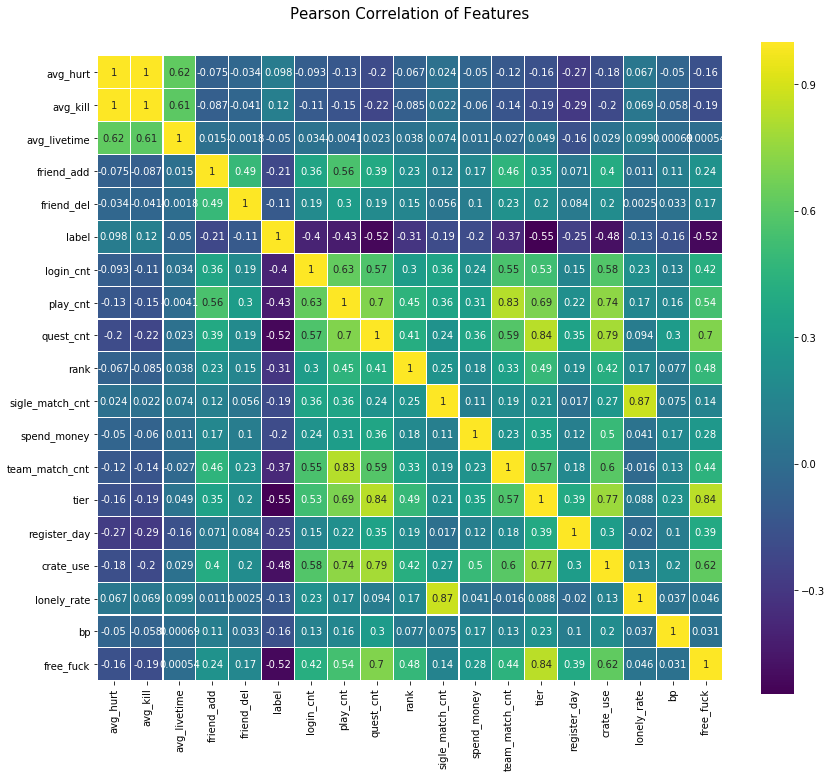

In [109]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_input.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [278]:
from sklearn.preprocessing import scale
def add_missing_cols(train_input, test_input):
    missing_cols = set(train_input.columns) - set(test_input.columns)
    print(missing_cols)
    for col in missing_cols:
        test_input[col] = 0
    missing_cols = set(test_input.columns) - set(train_input.columns)
    for col in missing_cols:
        train_input[col] = 0
# add_missing_cols(train_input, test_input)

y_train = train_input['label'].ravel()
train_input = train_input.drop(['label'], axis=1)
x_train = train_input.values # Creates an array of the train data
x_train = scale(x_train)
test_true = test_input['label'].ravel()
test_input = test_input.drop(['label'], axis=1)
x_test = test_input.values # Creats an array of the test data
x_test = scale(x_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(test_true.shape)

(229998, 19)
(229998,)
(32834, 19)
(32834,)


In [279]:
# from sklearn.decomposition import PCA
# np.set_printoptions(suppress=True)

# pca = PCA(n_components=10)
# newX = pca.fit_transform(x_train)

x_test

array([[-0.53025297, -0.47158152,  0.06240173, ..., -1.13092431,
        -0.31695261, -0.82728395],
       [-0.53025297, -1.48162117,  0.06240173, ..., -0.26891514,
        -0.31695261, -0.82728395],
       [ 2.73653115,  0.53845812,  3.6887705 , ..., -0.26891514,
        -0.31695261,  0.35192339],
       ...,
       [-0.53025297, -0.47158152,  0.06240173, ..., -0.26891514,
        -0.31695261, -0.82728395],
       [-0.53025297,  1.54849776,  1.87558612, ..., -0.26891514,
        -0.31695261,  1.53113074],
       [ 2.73653115,  1.54849776,  0.06240173, ...,  0.59309402,
        -0.31695261,  1.53113074]])

In [286]:
from sklearn import metrics 
def get_scores(y_true, y_predicet):
    acc_score = metrics.accuracy_score(y_true,y_predicet)
    pre_score = metrics.precision_score(y_true,y_predicet)
    recall = metrics.recall_score(y_true,y_predicet)
    F1 = metrics.f1_score(y_true,y_predicet)
    print('准确率：',acc_score)
    print('精确率：',pre_score)
    print('召回率：',recall)
    print('F1-score:',F1)
    
from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression()
classifier = LogisticRegression(penalty='l2',dual=False,C=1.0,n_jobs=1,random_state=20,fit_intercept=True,class_weight={0:0.5, 1:0.5})
classifier.fit(x_train, y_train)
# classifier.score(x_test, test_true)
predictions = classifier.predict(x_train)
get_scores(y_train, predictions)

predictions = classifier.predict(x_test)
get_scores(test_true, predictions)

准确率： 0.7917938416855799
精确率： 0.7862200062324711
召回率： 0.9027731062368054
F1-score: 0.8404750403917585
准确率： 0.7591825546689407
精确率： 0.6846010220125787
召回率： 0.9035082030996693
F1-score: 0.7789673776311743


In [281]:
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pylab as plt
%matplotlib inline

gbm0= GradientBoostingClassifier(random_state=10)
gbm0.fit(x_train,y_train)
y_pred= gbm0.predict(x_train)
y_predprob= gbm0.predict_proba(x_train)[:,1]
get_scores(y_train, y_pred)
print("roc_auc_score: %f" % metrics.roc_auc_score(y_train, y_predprob))

print('-----------------------------')

y_pred= gbm0.predict(x_test)
y_predprob= gbm0.predict_proba(x_test)[:,1]
get_scores(test_true, y_pred)
print("roc_auc_score: %f" % metrics.roc_auc_score(test_true, y_predprob))

准确率： 0.7957243106461795
精确率： 0.7910286660976956
召回率： 0.902078935127205
F1-score: 0.8429119286361493
roc_auc_score: 0.852793
-----------------------------
准确率： 0.793780836937321
精确率： 0.735643456467255
召回率： 0.8755593022501783
F1-score: 0.7995262768319763
roc_auc_score: 0.854842


In [248]:
cols = train_input.columns.values
feature_dataframe = pd.DataFrame({
    'features': cols,
    'GBDT': gbm0.feature_importances_
})

feature_dataframe.sort_valwqes('GBDT', ascending = False)

,features,GBDT
4,friend_del,0.000000
1,avg_kill,0.000371
10,spend_money,0.000396
15,lonely_rate,0.000578
2,avg_livetime,0.001071
3,friend_add,0.001089
0,avg_hurt,0.001237
9,sigle_match_cnt,0.002158
8,rank,0.004458
17,bp,0.005612


In [193]:
from sklearn.model_selection import GridSearchCV
param_test1= {'n_estimators':range(20,81,10)}
gsearch1= GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,min_samples_split=300,min_samples_leaf=20,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10),
param_grid= param_test1, scoring='roc_auc',iid=False,cv=5)
gsearch1.fit(x_train,y_train)

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [194]:
print(gsearch1.cv_results_['mean_test_score'])
print(gsearch1.cv_results_['std_test_score'])
print(gsearch1.cv_results_['rank_test_score'])
print(gsearch1.cv_results_['params'])

[0.91886873 0.91987055 0.92051895 0.92095941 0.92107274 0.92118217
 0.9210679 ]
[0.00346838 0.00369104 0.00390342 0.00399314 0.00383801 0.00393989
 0.00379146]
[7 6 5 4 2 1 3]
[{'n_estimators': 20}, {'n_estimators': 30}, {'n_estimators': 40}, {'n_estimators': 50}, {'n_estimators': 60}, {'n_estimators': 70}, {'n_estimators': 80}]


In [197]:
param_test2= {'max_depth':range(3,14,2), 'min_samples_split':range(100,801,200)}
gsearch2= GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,n_estimators=70, min_samples_leaf=20, max_features='sqrt', subsample=0.8,random_state=10),
param_grid= param_test2,scoring='roc_auc',iid=False,cv=5)
gsearch2.fit(x_train,y_train)
print(gsearch1.cv_results_['mean_test_score'])
print(gsearch1.cv_results_['std_test_score'])
print(gsearch1.cv_results_['rank_test_score'])
print(gsearch1.cv_results_['params'])

[0.91886873 0.91987055 0.92051895 0.92095941 0.92107274 0.92118217
 0.9210679 ]
[0.00346838 0.00369104 0.00390342 0.00399314 0.00383801 0.00393989
 0.00379146]
[7 6 5 4 2 1 3]
[{'n_estimators': 20}, {'n_estimators': 30}, {'n_estimators': 40}, {'n_estimators': 50}, {'n_estimators': 60}, {'n_estimators': 70}, {'n_estimators': 80}]


In [202]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 9, 'min_samples_split': 700}, 0.9216744666532133)

In [209]:
param_test3= {'min_samples_split':range(400,1900,200),'min_samples_leaf':range(20,101,10)}
gsearch3= GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,n_estimators=70,max_depth=9,max_features='sqrt',subsample=0.8,random_state=10),
                       param_grid=param_test3,scoring='roc_auc',iid=False,cv=5)
gsearch3.fit(x_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 60, 'min_samples_split': 400}, 0.921520807656764)

In [250]:
from sklearn.ensemble import GradientBoostingClassifier
gbm1= GradientBoostingClassifier(learning_rate=0.05, n_estimators=140,max_depth=9,min_samples_leaf =60, min_samples_split =400, max_features='sqrt',subsample=0.8, random_state=10)
gbm1.fit(x_train,y_train)
y_pred= gbm1.predict(x_train)
y_predprob= gbm1.predict_proba(x_train)[:,1]
get_scores(y_train, y_pred)
print("roc_auc_score: %f" % metrics.roc_auc_score(y_train, y_predprob))

print('-----------------------------')

y_pred= gbm1.predict(x_test)
y_predprob= gbm1.predict_proba(x_test)[:,1]
get_scores(test_true, y_pred)
print("roc_auc_score: %f" % metrics.roc_auc_score(test_true, y_predprob))

准确率： 0.8010895746919539
精确率： 0.7964296978489875
召回率： 0.9035531541847067
F1-score: 0.8466162640604831
roc_auc_score: 0.858638
-----------------------------
准确率： 0.7776694889443869
精确率： 0.7904714214178411
召回率： 0.7165553466052785
F1-score: 0.7517006802721089
roc_auc_score: 0.859807
